# Group project - Computational Game Theory

# Playing Matching pennies game

In this game 2 agents compete with each other in a matching pennies game.
Both players can heve their own learning algorithms assigned to make comparing different learners possible.
This is done in an abstract way to make testing alternate situations easy.

## TOC
- Group info
- Important note
- Required imports
- Storing and loading variables
- Code to represent the players and games
   - The MatchingPenniesPlayer class
   - The MatchingPenniesGame class

## Student info
| Name     | Student number                        | Email address                               |
| :---     | :---                          | :---                                |
| Alexis Francois Verdoodt | _ | _ |
| Lennert Bontinck | 568702 | [lennert.bontinck@vub.be](mailto:lennert.bontinck@vub.be) |
| Sofyan Ajridi | _ | _ |
| Wolf De Wulf | 546395 | [wolf.de.wulf@vub.be](mailto:wolf.de.wulf@vub.be) |

## Important note
In some codeblocks, the code might refer to variables from previous sections, in order to get accurate results code must be run top to bottom without skipping. The result of some lengthy processes is saved to a Pickle file to make the results available for reuse later.

## Required imports

In [87]:
# General imports
import numpy as np
import random
import statistics as stats
import math
from scipy import stats as sstats

# Allow for deep copying
import copy

# Plotting imports
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'svg'}

# Library to save vars to files
import pickle

## Storing and loading variables

In [88]:
def save_var_to_file(filename, network):
    with open('savefiles/' + filename +'.pkl','wb') as f:
        pickle.dump(network, f)

def get_var_from_file(filename):
    with open('savefiles/' + filename +'.pkl','rb') as f:
        return pickle.load(f)
    
    
#-------------------------

#save to file example
#save_var_to_file("folder/name", var_to_save)
    
#open from file example
#get_var_from_file = get_var_from_file("folder/name")

## Code to represent the players and games
Let's start by making a way of representing the games and playing them in an abstract manner.

### The MatchingPenniesPlayer class
A class for defining a matching pennies player.

In [124]:
class MatchingPenniesPlayer:
    """
    A class used to represent a matching pennies player.

    ...

    Attributes
    ----------
    xxx : xxx
        xxx

    Methods
    -------
    xxx(yyy)
        xxx
    """
    def __init__(self, initial_q_value, initial_policy_probabilities, alpha, gamma,
                 winning_learning_rate, losing_learning_rate):
        """
        Parameters
        ----------
        initial_q_value : decimal
            Decimal representing the initial value of the q_values.
        initial_policy_probabilities : decimal
            Decimal representing the initial value of the policy_probabilities and average_policy_probabilities.
        alpha : decimal
            Decimal representing alpha for updating q value estimations.
        gamma : decimal
            Decimal representing alpha for updating gamma value estimations.
        winning_learning_rate : decimal
            decimal representing winning learning rate (delta).
        losing_learning_rate : decimal
            decimal representing losing learning rate (delta).
        """
        self.q_values = [initial_q_value]*2
        self.policy_probabilities = [initial_policy_probabilities, initial_policy_probabilities]
        self.average_policy_probabilities = [initial_policy_probabilities, initial_policy_probabilities]
        self.alpha = alpha
        self.gamma = gamma
        self.actions = [i for i in range(2)]
        self.winning_delta = winning_learning_rate
        self.losing_delta = losing_learning_rate
        self.state_count = 0
        

    def update_q_value_for_action(self, action, received_reward):
        crt_alpha = self.timed_alpha()
        self.q_values[action] = ((1-crt_alpha) * self.q_values[action]) + crt_alpha * (received_reward + self.gamma * np.max(self.q_values))
        
    def choose_action(self):
        cum_probs = np.cumsum(self.policy_probabilities)
        
        # some exploration
        if  random.random() < 0.05:
            return random.choice(self.actions)
        
        # chose an action for the cumulative probs
        rnd = random.random()
        for idx in range(len(cum_probs)):
            if (rnd < cum_probs[idx]):
                return idx
                
    def increment_state_count(self):
        self.state_count += 1
            
    def update_average_policy_probabilities(self, chosen_action):
        for action in self.actions:
            c = self.state_count
            polprob = self.policy_probabilities[action]
            avgpolprob = self.average_policy_probabilities[action]
            self.average_policy_probabilities[action] += (1/c)*(polprob-avgpolprob)

    def player_is_winning(self):
        policy_sum = 0
        avg_policy_sum = 0
        for action in self.actions:
            policy_sum += self.policy_probabilities[action] * self.q_values[action]
            avg_policy_sum += self.average_policy_probabilities[action] * self.q_values[action]
            
        return policy_sum > avg_policy_sum
        
    def timed_alpha(self):
        return 1 / (100 + (self.state_count/10000))
    
    def timed_delta(self): 
        return 1 / (20000 + self.state_count)
    
    def update_policy_probabilities(self):
        #determine delta
        delta = self.timed_delta() if self.player_is_winning() else 2 * self.timed_delta()
        
        #determine 1 max q-value
        max_action = np.argmax(self.q_values)
        
        for action in self.actions:
            if action == max_action:
                self.policy_probabilities[action] = min(1.0,  self.policy_probabilities[action] + delta)
            else:
                self.policy_probabilities[action] = max(0.0,  self.policy_probabilities[action] - delta)            

### The MatchingPenniesGame class
This game does't require the notion of states since the results are indepent of a given state. Thus the transition function can simply return the initial start state for every iteration.

In [125]:
class MatchingPenniesGame:
    """
    A class used to represent a matching pennies game.
    """
    def __init__(self, players):
        self.players = players
        self.payoff_matrix = [[1, -1], [-1,1]]
        
    def play_game(self, iterations, trials):
        results = [[[0]*iterations, [0]*iterations] for _ in range(trials)]
        
        # determine player moves
        for trial in range(trials):
            for iteration in range(iterations):
                player1_move = self.players[0].choose_action()
                player2_move = self.players[1].choose_action()

                # add to state count
                self.players[0].increment_state_count()
                self.players[1].increment_state_count()
                
                # calculate corresponding reward and update q-value
                reward = self.payoff_matrix[player1_move][player2_move]
                self.players[0].update_q_value_for_action(player1_move, reward)
                self.players[1].update_q_value_for_action(player2_move, -reward)

                # update estimate of average policy
                self.players[0].update_average_policy_probabilities(player1_move)
                self.players[1].update_average_policy_probabilities(player2_move)

                # update policy
                self.players[0].update_policy_probabilities()
                self.players[1].update_policy_probabilities()

                # save result player1
                results[trial][0][iteration] = copy.deepcopy(self.players[0].policy_probabilities[0])
                # save result player2
                results[trial][1][iteration] = copy.deepcopy(self.players[1].policy_probabilities[1])
                
        return results

## Playing the game

In [ ]:
initial_q_value = 0
initial_policy_probabilities = 1/2
alpha = 0.2
gamma = 0.8
winning_learning_rate = 0.1
losing_learning_rate = 0.2
iterations = 1000000
averaging_amount = 30

player1 = MatchingPenniesPlayer(initial_q_value, initial_policy_probabilities, alpha, gamma,
                                winning_learning_rate, losing_learning_rate)

player2 = MatchingPenniesPlayer(initial_q_value, initial_policy_probabilities, alpha, gamma,
                                winning_learning_rate, losing_learning_rate)

players = [player1, player2]

game = MatchingPenniesGame(players)

results = game.play_game(iterations, averaging_amount)
results
save_var_to_file("matching_pennies/wolf_result", results)


## Plotting

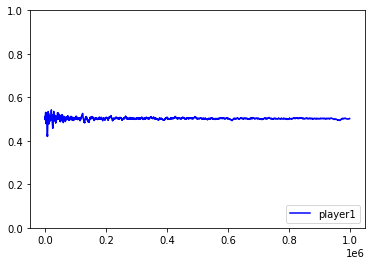

In [127]:
# get the results
results = [["player1", get_var_from_file("matching_pennies/result")]]

colors = ["blue",
         "orange",]

# --------------------------------------------------------------------------

color_idx = 0
for result in results:
    x = np.arange(len(result[1]))
    y = result[1]
    plt.plot(x, y,
             "-",
             label=result[0],
             color=colors[color_idx])
           
    color_idx += 1
        
plt.legend(loc="lower right")

plt.ylim(0, 1)

#plt.xlabel('probability playing heads')
#plt.ylabel('average reward')
#plt.title('average reward over time\n ' + str(iterations) + " iterations, " + str(averaging_amount) + " runs")

#plt.savefig("graphs/todo", dpi=300)
plt.show()